<a href="https://colab.research.google.com/github/Pburman953/ModBot/blob/main/ModBot_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import re
import string
import zipfile

#import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import spacy
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.utils.data import Dataset

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter



```
# This is formatted as code
```

# DATA AND ANALYSIS


In [95]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
pd.set_option('display.max_colwidth', None)
training_data = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/train.csv/train.csv')
print(training_data.shape)

print(training_data.head(500))

(159571, 8)
                   id  \
0    0000997932d777bf   
1    000103f0d9cfb60f   
2    000113f07ec002fd   
3    0001b41b1c6bb37e   
4    0001d958c54c6e35   
..                ...   
495  014b44616d8cb457   
496  014bb932bd289352   
497  014c96f873db11ff   
498  014d00c8f2a76df4   
499  014f50b1f448cb2d   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [97]:
pd.set_option('display.max_colwidth', None)
testing_data = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/test.csv/test.csv')
print(testing_data.shape)

print(testing_data.head(500).to_string(index=False))

(153164, 2)
              id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [98]:
pd.set_option('display.max_colwidth', None)
testing_data_labels = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/test_labels.csv/test_labels.csv')
print(testing_data_labels.shape)

print(testing_data_labels.to_string(index=False))


Streaming output truncated to the last 5000 lines.
f79dd1fb92ab9ae6     -1            -1       -1      -1      -1             -1
f79dd55171e29ff4      0             0        0       0       0              0
f79de2c201de354b      0             0        0       0       0              0
f79e71dd2f8c8c0d     -1            -1       -1      -1      -1             -1
f79ef4f6aac10d09      0             0        0       0       0              0
f7a05be4a1a1e6e1     -1            -1       -1      -1      -1             -1
f7a0774c320e1917      0             0        0       0       0              0
f7a0e4597871ead4      0             0        0       0       0              0
f7a11cf11e311a6e     -1            -1       -1      -1      -1             -1
f7a1418bfffd611c     -1            -1       -1      -1      -1             -1
f7a14add4307d9eb     -1            -1       -1      -1      -1             -1
f7a158cff138cc04      0             0        0       0       0              0
f7a1ddd8aed97

eda

In [99]:
import seaborn as sns
plt.style.use('ggplot')


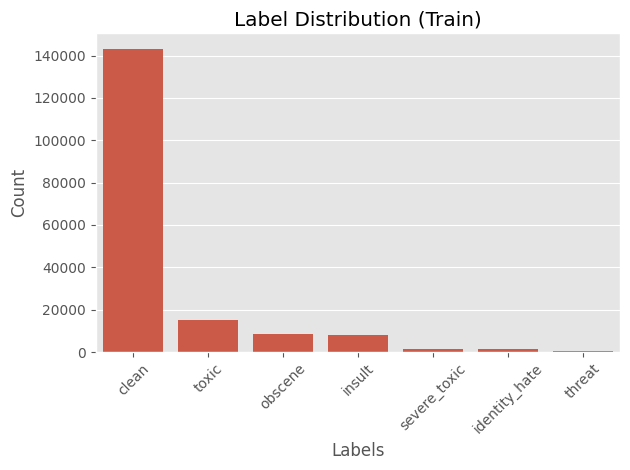

In [100]:
# List of label columns
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Count how many comments are clean (i.e., all 0s across labels)
training_data["clean"] = (training_data[label_cols].sum(axis=1) == 0).astype(int)
clean_count = training_data["clean"].sum()

# Melt the dataframe so each label becomes a row
melted = training_data[label_cols].melt(var_name='label', value_name='value')
melted = melted[melted['value'] == 1]

# Add the "clean" rows manually (fix: same length for both columns)
clean_df = pd.DataFrame({
    "label": ["clean"] * clean_count,
    "value": [1] * clean_count
})

# Combine toxic + clean labels
melted_with_clean = pd.concat([melted, clean_df], ignore_index=True)

# Plot
sns.countplot(x='label', data=melted_with_clean, order=melted_with_clean['label'].value_counts().index)
plt.title("Label Distribution (Train)")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

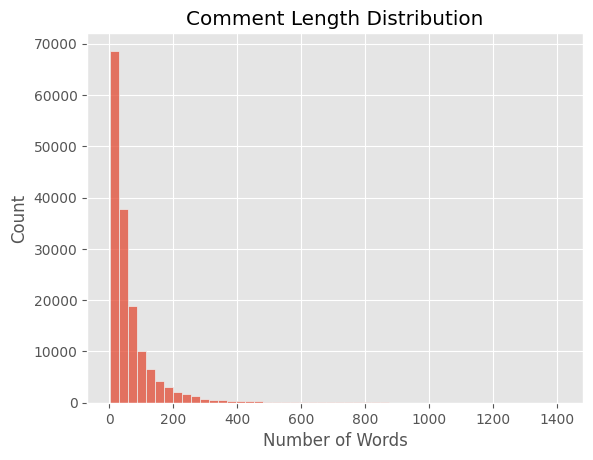

In [101]:
training_data["comment_text_len"] = training_data["comment_text"].apply(lambda x: len(x.split()))
sns.histplot(training_data["comment_text_len"], bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Number of Words")
plt.show()


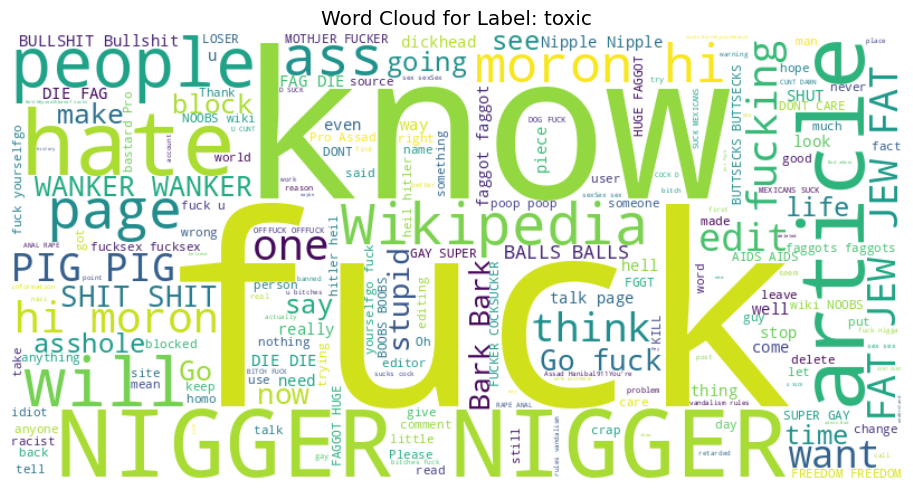

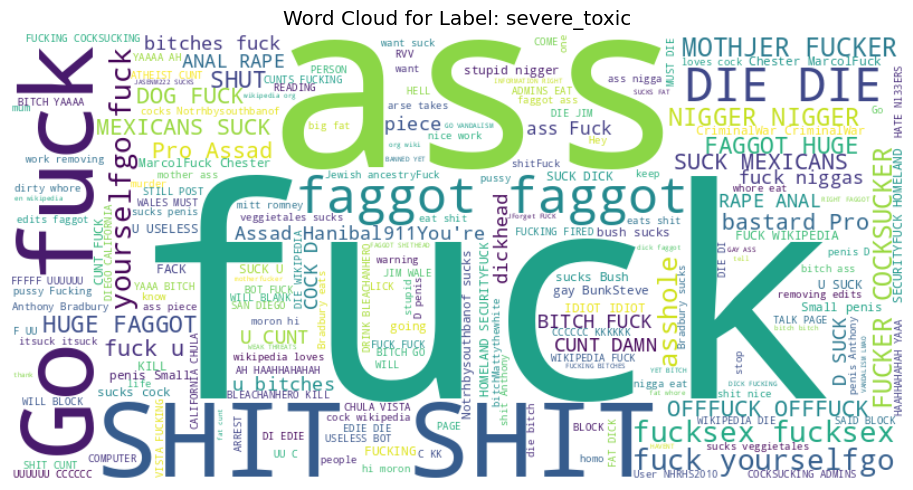

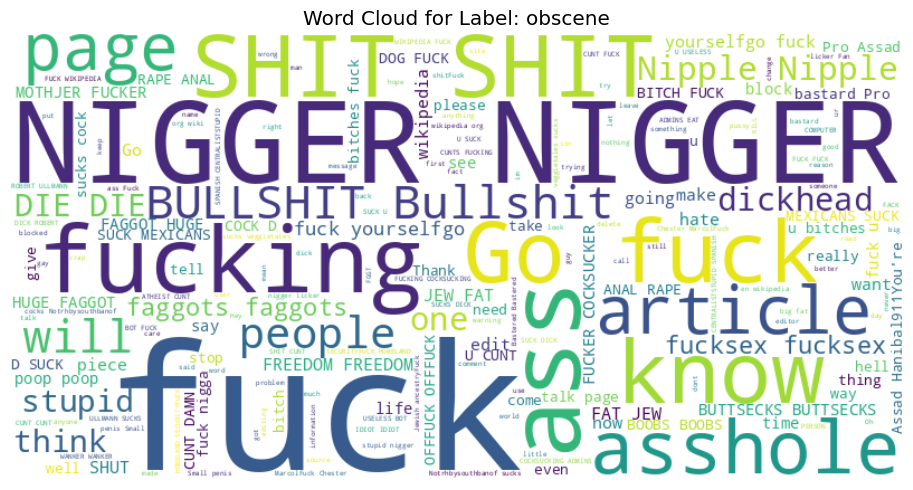

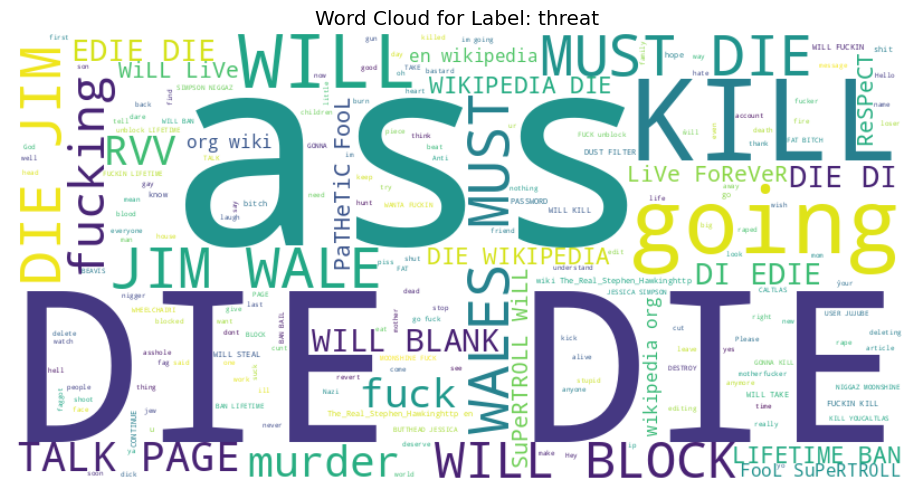

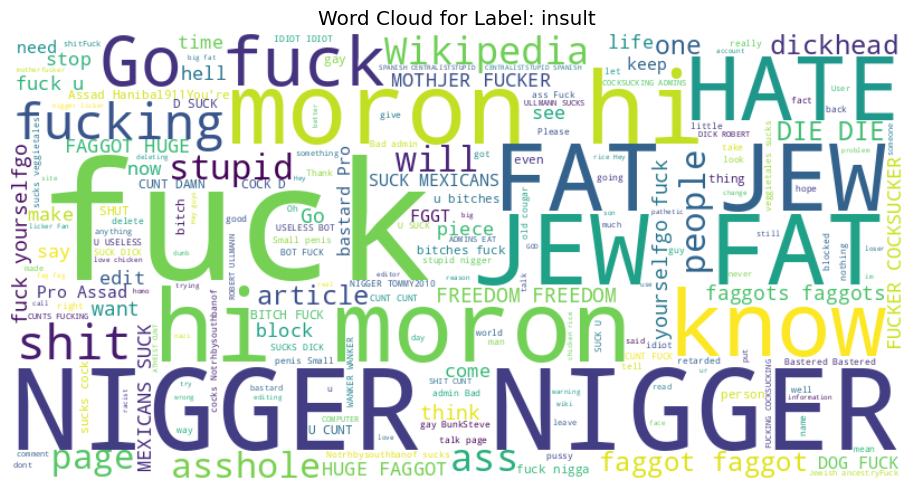

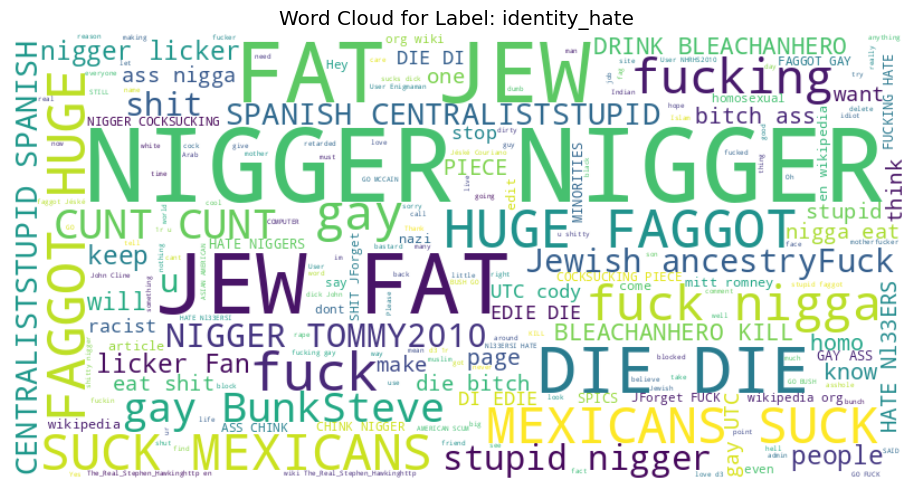

In [102]:
from wordcloud import WordCloud

# Assuming 'comment_text' is your text column
text_column = "comment_text"  # Adjust this if your column name is different
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for label in label_cols:
    # Filter comments where the label is 1
    text = " ".join(training_data[training_data[label] == 1][text_column].astype(str))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Label: {label}")
    plt.tight_layout()
    plt.show()

Top words for label: toxic


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


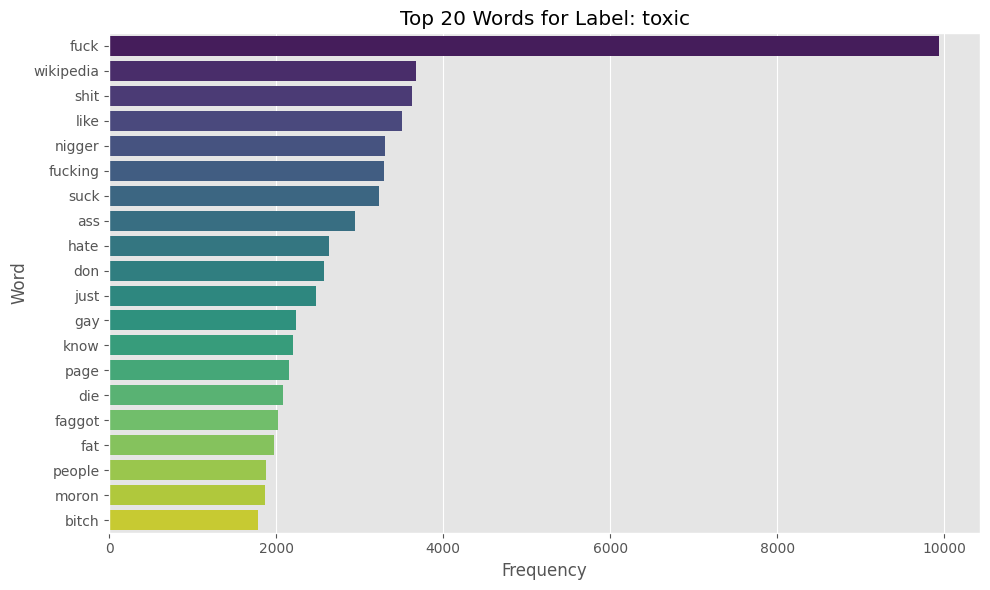

Top words for label: severe_toxic


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


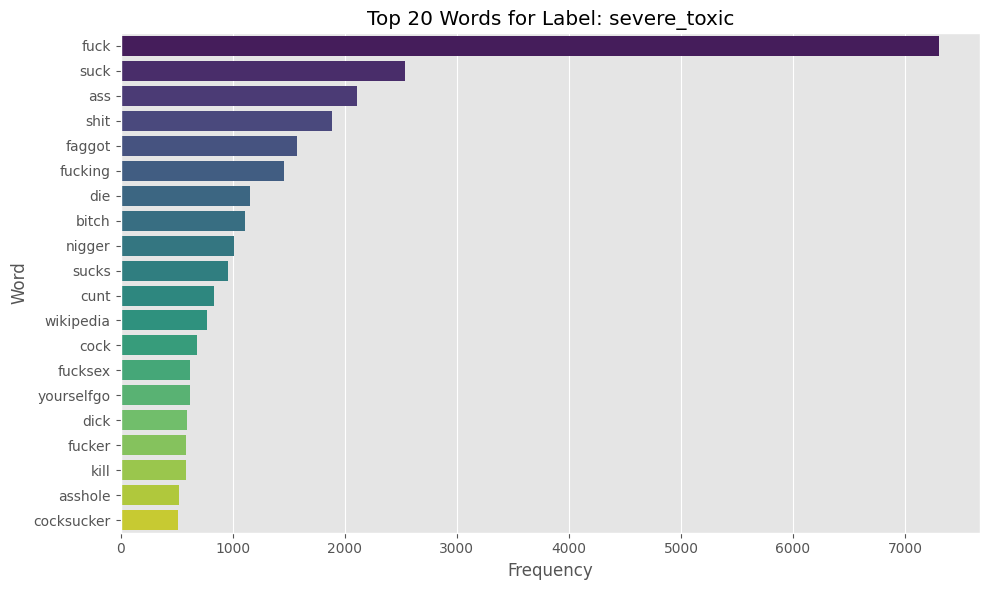

Top words for label: obscene


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


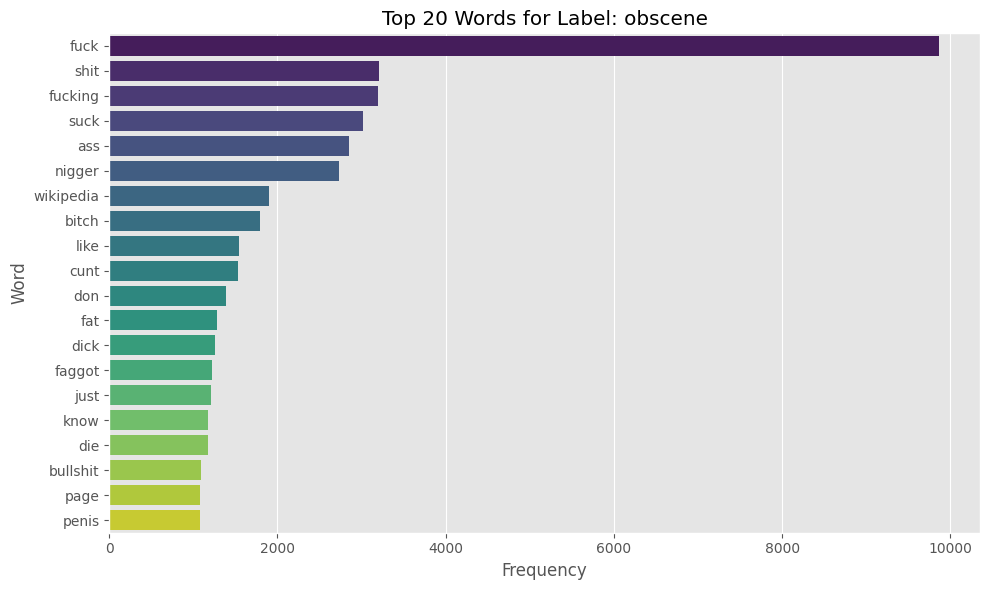

Top words for label: threat


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


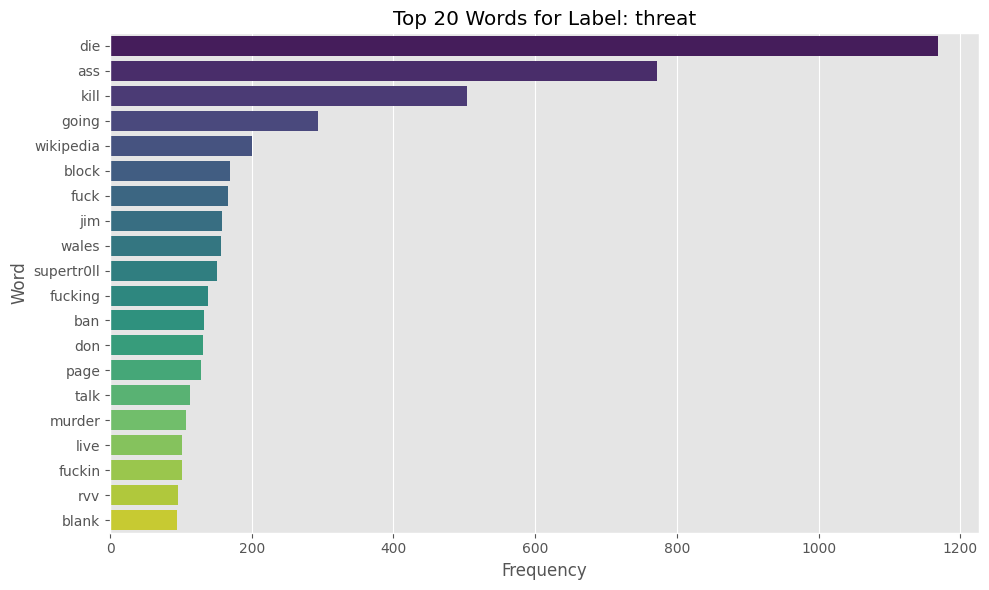

Top words for label: insult


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


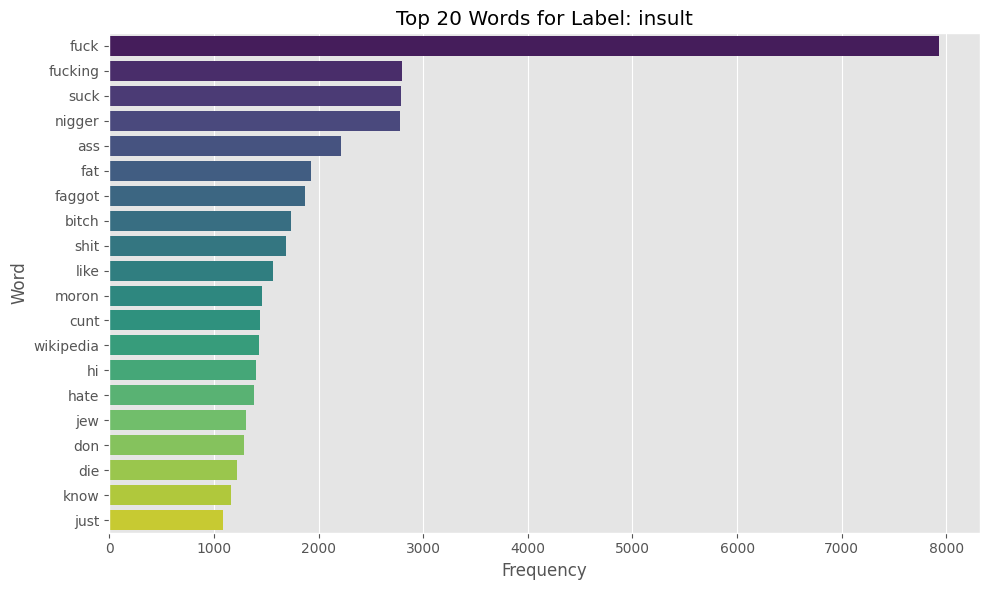

Top words for label: identity_hate


<ipython-input-103-9fc4fe2e17fe>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


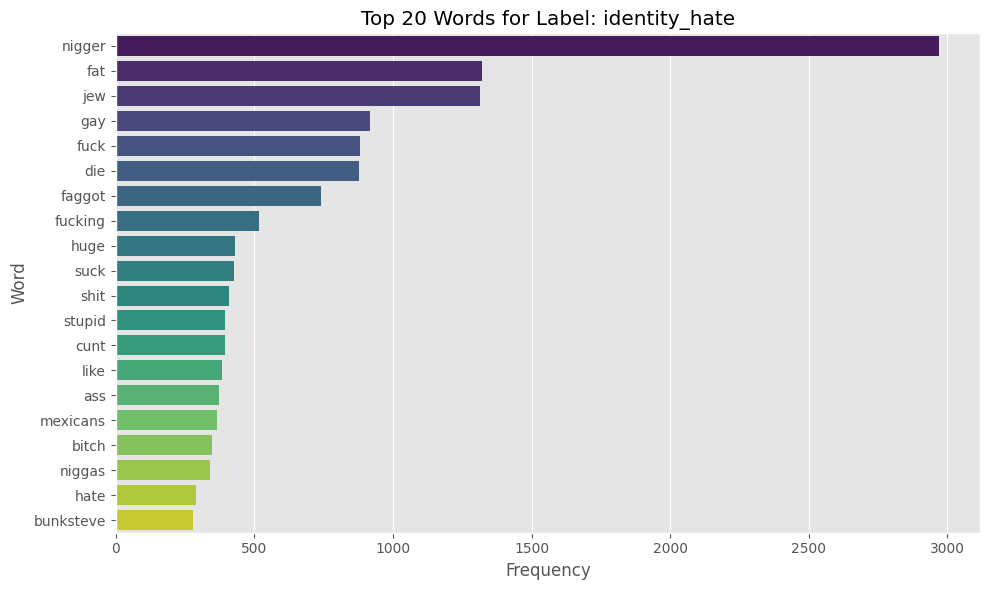

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


# Loop through each label
for label in label_cols:
    print(f"Top words for label: {label}")

    # Filter comments where the label is 1
    filtered_text = training_data[training_data[label] == 1][text_column].dropna().astype(str)

    # Vectorize the text
    vec = CountVectorizer(stop_words='english', max_features=1000)
    X_counts = vec.fit_transform(filtered_text)
    word_counts = X_counts.sum(axis=0).A1
    words = vec.get_feature_names_out()

    # Create a DataFrame of word counts
    freq_df = pd.DataFrame({"word": words, "count": word_counts})
    top_words = freq_df.sort_values(by="count", ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_words, x="count", y="word", palette="viridis")
    plt.title(f"Top 20 Words for Label: {label}")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

# DATA PREPROCESSING

In [104]:
import nltk
nltk.download('stopwords')

punc = string.punctuation
punc.replace('#', '')
punc.replace('!', '')
punc.replace('?', '')
punc = punc + "∞θ÷α•à−β∅³π‘₹´°£€\×™√²—"

chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}


stpwds = stopwords.words('english')


time_zone_abbreviations = [
        "UTC", "GMT", "EST", "CST", "PST", "MST",
        "EDT", "CDT", "PDT", "MDT", "CET", "EET",
        "WET", "AEST", "ACST", "AWST", "HST",
        "AKST", "IST", "JST", "KST", "NZST"
    ]

patterns = [
    r'\\[nrtbfv\\]',         # \n, \t ..etc
    '<.*?>',                 # Html tags
    r'https?://\S+|www\.\S+',# Links
    r'\ufeff',               # BOM characters
    r'^[^a-zA-Z0-9]+$',      # Non-alphanumeric tokens
    r'ｗｗｗ．\S+',            # Full-width URLs
    r'[\uf700-\uf7ff]',      # Unicode private-use chars
    r'^[－—…]+$',            # Special punctuation-only tokens
    r'[︵︶]'                # CJK parentheses
]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["                         # Start of group
        "\U0001F600-\U0001F64F"     # Emoticons
        "\U0001F300-\U0001F5FF"     # Symbols & pictographs
        "\U0001F680-\U0001F6FF"     # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"     # Flags
        "\U00002700-\U000027BF"     # Dingbats
        "\U000024C2-\U0001F251"     # Enclosed characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [106]:
def preprocess(text):
    for regex in patterns:
        text = re.sub(regex, '', text)
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))
    text = ' '.join(word for word in text.split() if word not in time_zone_abbreviations)
    text = ' '.join(word for word in text.split() if word not in stpwds)
    text = ' '.join(chat_words.get(word.lower(), word) for word in text.split())
    text = text.lower()
    text = remove_emojis(text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [107]:
import nltk
nltk.download('punkt_tab')

comments = list(training_data["comment_text"])

# --- Tokenize and Build Vocabulary ---
token_lists = []
for comment in comments:
    cleaned = preprocess(comment)
    tokens = word_tokenize(cleaned)
    filtered = [t for t in tokens if 1 < len(t) < 25]
    token_lists.append(filtered)

# Flatten all tokens and build counter
all_tokens = [token for sublist in token_lists for token in sublist]
token_freq = Counter(all_tokens)

# --- Limit to top 30,000 words + <pad>, <unk> ---
vocab_size = 30000
special_tokens = ["<pad>", "<unk>"]
most_common_tokens = [token for token, _ in token_freq.most_common(vocab_size)]
final_vocab = special_tokens + most_common_tokens

# --- Create word-to-index mapping ---
word_to_index = {word: idx for idx, word in enumerate(final_vocab)}
PAD_IDX = word_to_index["<pad>"]
UNK_IDX = word_to_index["<unk>"]

# --- Display ---
print(f"Final vocabulary size: {len(final_vocab)}")
print("Sample valid tokens:", final_vocab[2:12])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Final vocabulary size: 30002
Sample valid tokens: ['article', 'the', 'page', 'wikipedia', 'talk', 'you', 'please', 'would', 'one', 'like']


In [108]:
torch.save(final_vocab, "vocab.pth")


In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print out the device information
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [110]:
def text_pipeline(text):
    return [
        final_vocab[token] if token in final_vocab else final_vocab['<unk>']
        for token in word_tokenize(text)  # Using NLTK's word_tokenize
    ]

def label_pipeline(labels):
    return torch.FloatTensor(labels)

In [111]:

class PaddedDataset(Dataset):
    def __init__(self, df, vocab, word_to_index, max_length=None):
        self.df = df
        self.vocab = vocab
        self.word_to_index = word_to_index
        self.max_length = max_length
        self.label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['comment_text']
        labels = self.df.iloc[idx][self.label_cols].values.astype(float)

        # Tokenize with NLTK and numericalize
        tokens = word_tokenize(preprocess(text))
        if self.max_length:
            tokens = tokens[:self.max_length]
        numericalized = [self.word_to_index.get(token, UNK_IDX) for token in tokens]

        return torch.tensor(numericalized, dtype=torch.long), torch.tensor(labels, dtype=torch.float)



def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
     # Filter invalid sequences (length <=0)
    valid_mask = lengths > 0
    if not valid_mask.all():
        texts = [t for t, valid in zip(texts, valid_mask) if valid]
        labels = [l for l, valid in zip(labels, valid_mask) if valid]
        lengths = lengths[valid_mask]

    # Add fallback for empty batch
    if len(texts) == 0:
        return torch.zeros((1,1), dtype=torch.long), torch.zeros((1,6)), torch.tensor([1])
    # Pad sequences to match longest in batch
    padded_texts = torch.nn.utils.rnn.pad_sequence(
        texts,
        batch_first=True,
        padding_value=PAD_IDX
    )

    return padded_texts, torch.stack(labels), lengths

In [112]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 256

dataset = PaddedDataset(training_data, final_vocab, word_to_index,max_length=MAX_SEQ_LEN)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    pin_memory=True,  # Faster data transfer to GPU
    num_workers=2     # Parallel data loading
)

# LSTM MODEL

In [113]:
class BIDirectional_lstm(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout =  nn.Dropout(p = 0.3)
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted = False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc1(hidden_output)
        out = self.dropout(out)
        return torch.sigmoid(out)

In [114]:
def train_model(model, train_loader, val_loader, epochs, learning_rate, filename):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.BCELoss()
    best_val_loss = float('inf')
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for texts, labels, lengths in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            # Move data to device
            texts, labels = texts.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.size(0)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for texts, labels, lengths in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts, lengths)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).all(dim=1).sum().item()
                val_total += labels.size(0)

        # Epoch Statistics
        train_loss /= len(train_loader)
        train_acc = correct / total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2%}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename + '.pth')

    print("Training complete!")

In [115]:
train_df, val_df = train_test_split(training_data.iloc[:, 1:], test_size=0.2)

train_dataset = PaddedDataset(train_df, final_vocab, word_to_index, max_length=256)
val_dataset = PaddedDataset(val_df, final_vocab, word_to_index, max_length=256)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_batch,
    pin_memory=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    collate_fn=collate_batch,
    pin_memory=True,
    num_workers=2
)

In [116]:
BIDirectional_model = BIDirectional_lstm(
    vocab_size=len(final_vocab),
    embed_dim=50,
    hidden_dim=256,
    output_dim=6,
    pad_idx=PAD_IDX
)

train_model(BIDirectional_model, train_loader, val_loader, 7, 0.0005, "bidirctional_lstm")

Epoch 1: 100%|██████████| 1995/1995 [02:29<00:00, 13.36it/s]



Epoch 1/7
Train Loss: 0.2779 | Acc: 89.66%
Val Loss: 0.0922 | Acc: 90.88%


Epoch 2: 100%|██████████| 1995/1995 [02:29<00:00, 13.34it/s]



Epoch 2/7
Train Loss: 0.2517 | Acc: 90.40%
Val Loss: 0.0644 | Acc: 91.54%


Epoch 3: 100%|██████████| 1995/1995 [02:29<00:00, 13.38it/s]



Epoch 3/7
Train Loss: 0.2454 | Acc: 90.69%
Val Loss: 0.0603 | Acc: 91.61%


Epoch 4: 100%|██████████| 1995/1995 [02:28<00:00, 13.44it/s]



Epoch 4/7
Train Loss: 0.2406 | Acc: 90.99%
Val Loss: 0.0548 | Acc: 91.92%


Epoch 5: 100%|██████████| 1995/1995 [02:30<00:00, 13.26it/s]



Epoch 5/7
Train Loss: 0.2375 | Acc: 91.10%
Val Loss: 0.0541 | Acc: 91.86%


Epoch 6: 100%|██████████| 1995/1995 [02:27<00:00, 13.49it/s]



Epoch 6/7
Train Loss: 0.2355 | Acc: 91.32%
Val Loss: 0.0500 | Acc: 92.05%


Epoch 7: 100%|██████████| 1995/1995 [02:28<00:00, 13.41it/s]



Epoch 7/7
Train Loss: 0.2323 | Acc: 91.55%
Val Loss: 0.0525 | Acc: 91.64%
Training complete!




# TESTING


In [117]:
ev_data = pd.concat([testing_data,testing_data_labels.iloc[:,1:]], axis=1)
ev_data = ev_data[ev_data['toxic']!= -1]
ev_data

id  \
5       0001ea8717f6de06   
7       000247e83dcc1211   
11      0002f87b16116a7f   
13      0003e1cccfd5a40a   
14      00059ace3e3e9a53   
...                  ...   
153150  fff8f64043129fa2   
153151  fff9d70fe0722906   
153154  fffa8a11c4378854   
153155  fffac2a094c8e0e2   
153156  fffb5451268fb5ba   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 comment_text  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Thank you for understanding. I think very highly of you and would not revert without discussion.   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            :Dear god this site is horrible.   
11                                                                                                                                                        "::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \n\n "   
13                                                                                               " \n\n It says it right there that it IS a type. The ""Type"" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it's not because I am totally right in this case."   
14                                                                                                                                                                                                                                                                        " \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, ""proving"" it's relevance and giving the reader the possibility to read more about it. \n Otherwise it could be subject to deletion. See this article's revision history."   
...                            

In [118]:
eval_dataset = PaddedDataset(ev_data, final_vocab,word_to_index, max_length=256)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=512,
    collate_fn=collate_batch,
    pin_memory=True,
    num_workers=2
)

In [119]:
def calc_roc(model):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for texts, labels, lengths in eval_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts, lengths)

            # Store batch results
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    # Concatenate all batches
    all_labels = np.concatenate(all_labels, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)

    # Calculate ROC-AUC for each class
    roc_scores = []
    for col in range(6):  # the original evaluation method is to take ROC-AUC scores average for the 6 classed
        if np.sum(all_labels[:, col]) > 0:
            roc = roc_auc_score(all_labels[:, col], all_outputs[:, col])
            roc_scores.append(roc)

    # Return average
    return np.mean(roc_scores)

In [120]:
from sklearn.metrics import multilabel_confusion_matrix


def plot_confusion_matrices(model, class_names):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for texts, labels, lengths in eval_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts, lengths)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_outputs, axis=0)
    y_pred_binary = (y_pred >= 0.5).astype(int)

    conf_matrices = multilabel_confusion_matrix(y_true, y_pred_binary)

    # Plot each class's confusion matrix
    for i, (matrix, class_name) in enumerate(zip(conf_matrices, class_names)):
        plt.figure(figsize=(4, 3))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not "+class_name, class_name], yticklabels=["Not "+class_name, class_name])
        plt.title(f'Confusion Matrix for "{class_name}"')
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

BiDirectional lstm model roc-auc  0.967471216557587


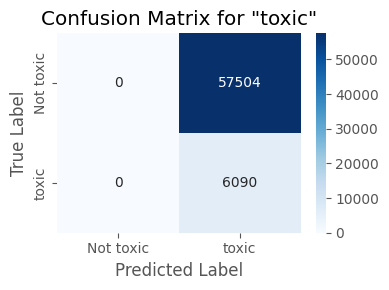

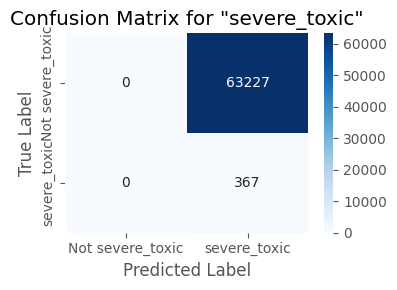

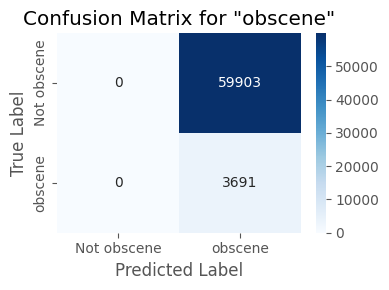

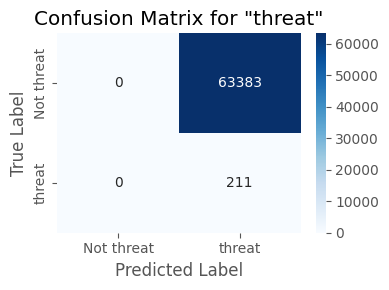

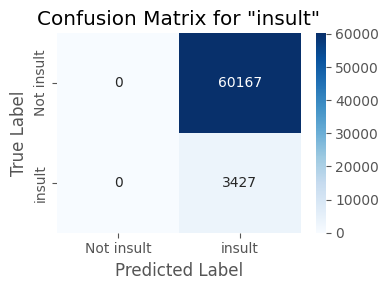

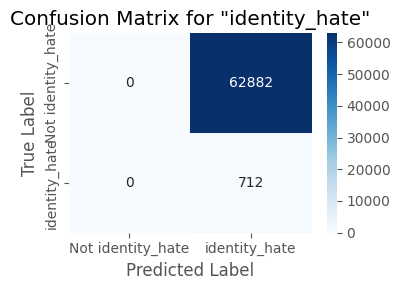

In [121]:
bi_lstm_model = BIDirectional_model = BIDirectional_lstm(
    vocab_size=len(final_vocab),
    embed_dim=50,
    hidden_dim=256,
    output_dim=6,
    pad_idx=PAD_IDX
).to(device)

class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


bi_lstm_model.load_state_dict(torch.load("bidirctional_lstm.pth"))

print("BiDirectional lstm model roc-auc ", calc_roc(bi_lstm_model))
plot_confusion_matrices(bi_lstm_model, class_names)

# ADDING GLOVE EMBEDDINGS

In [122]:
def load_glove_from_file(glove_file):
    word_to_vec = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            parts = line.split()
            word = parts[0]
            vector = np.array([float(val) for val in parts[1:]], dtype=np.float32)
            word_to_vec[word] = vector
    return word_to_vec

# Load GloVe file
glove_path = '/content/drive/MyDrive/University/Comp 3000/glove.6B/glove.6B.100d.txt'
glove_vectors = load_glove_from_file(glove_path)

# Create embedding matrix
def create_embedding_matrix(vocab, embedding_dim=100):
    vocab_size = len(vocab)
    weights = torch.zeros(vocab_size, embedding_dim)

    # Iterate directly through the vocabulary list using enumerate
    for idx, word in enumerate(vocab):
        if word in glove_vectors:
            weights[idx] = torch.tensor(glove_vectors[word])
        elif word == "<pad>":
            weights[idx] = torch.zeros(embedding_dim)  # Pad token
        else:
            # Initialize unknown words randomly
            weights[idx] = torch.randn(embedding_dim) * 0.25

    return weights

Loading GloVe: 400000it [00:11, 34375.38it/s]


In [123]:
class BI_lstm_GloVe_model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, output_dim):
        super().__init__()
        # Initialize with GloVe weights
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted = False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden_output)
        return torch.sigmoid(out)

In [124]:
embedding_dim = 100  # matches GloVe dimension
vocab_size = len(final_vocab)
bi_lstm_glove_model = BI_lstm_GloVe_model(
    vocab_size,
    embedding_dim,
    hidden_dim = 256,
    pad_idx = PAD_IDX,
    output_dim = 6
)

# Create embedding matrix
weights = create_embedding_matrix(final_vocab, 100)
# Assign to model
bi_lstm_glove_model.embedding = nn.Embedding.from_pretrained(weights, freeze=False)

In [125]:
train_model(bi_lstm_glove_model, train_loader, val_loader, 10, 0.0005, "bi_lstm_glove")

Epoch 1: 100%|██████████| 1995/1995 [02:28<00:00, 13.39it/s]



Epoch 1/10
Train Loss: 0.0668 | Acc: 91.01%
Val Loss: 0.0499 | Acc: 92.00%


Epoch 2: 100%|██████████| 1995/1995 [02:28<00:00, 13.45it/s]



Epoch 2/10
Train Loss: 0.0445 | Acc: 92.33%
Val Loss: 0.0446 | Acc: 92.25%


Epoch 3: 100%|██████████| 1995/1995 [02:26<00:00, 13.60it/s]



Epoch 3/10
Train Loss: 0.0390 | Acc: 92.77%
Val Loss: 0.0428 | Acc: 92.26%


Epoch 4: 100%|██████████| 1995/1995 [02:28<00:00, 13.48it/s]



Epoch 4/10
Train Loss: 0.0348 | Acc: 93.37%
Val Loss: 0.0446 | Acc: 91.74%


Epoch 5: 100%|██████████| 1995/1995 [02:30<00:00, 13.24it/s]



Epoch 5/10
Train Loss: 0.0313 | Acc: 93.84%
Val Loss: 0.0465 | Acc: 92.16%


Epoch 6: 100%|██████████| 1995/1995 [02:28<00:00, 13.45it/s]



Epoch 6/10
Train Loss: 0.0280 | Acc: 94.47%
Val Loss: 0.0505 | Acc: 90.97%


Epoch 7: 100%|██████████| 1995/1995 [02:26<00:00, 13.62it/s]



Epoch 7/10
Train Loss: 0.0226 | Acc: 95.63%
Val Loss: 0.0540 | Acc: 91.87%


Epoch 8: 100%|██████████| 1995/1995 [02:28<00:00, 13.44it/s]



Epoch 8/10
Train Loss: 0.0215 | Acc: 95.82%
Val Loss: 0.0557 | Acc: 91.75%


Epoch 9: 100%|██████████| 1995/1995 [02:28<00:00, 13.40it/s]



Epoch 9/10
Train Loss: 0.0207 | Acc: 95.97%
Val Loss: 0.0576 | Acc: 91.74%


Epoch 10: 100%|██████████| 1995/1995 [02:28<00:00, 13.47it/s]



Epoch 10/10
Train Loss: 0.0197 | Acc: 96.20%
Val Loss: 0.0584 | Acc: 91.78%
Training complete!


BiDirectional lstm with pretrained embedding model roc-auc  0.9778705850458457


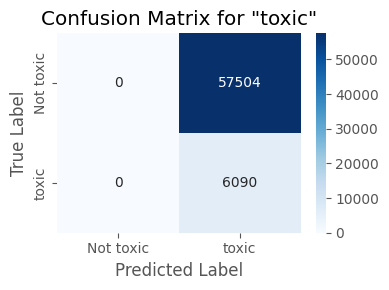

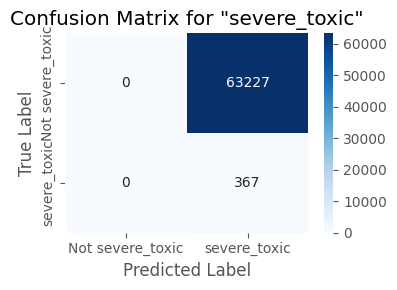

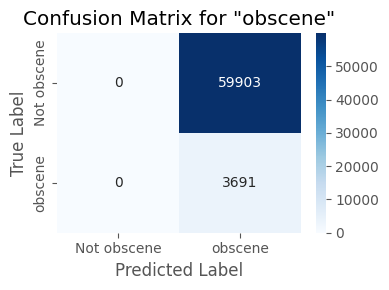

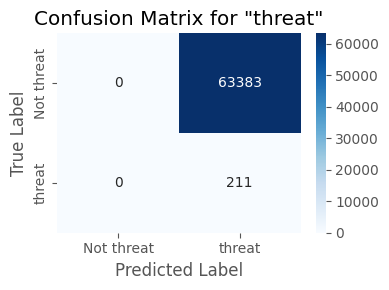

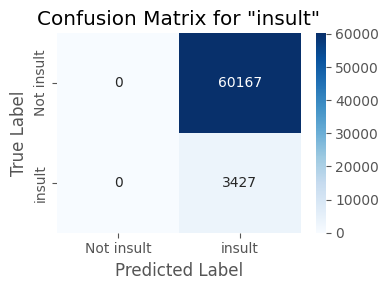

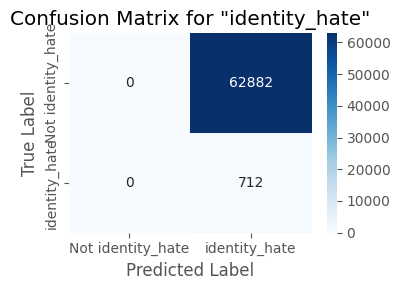

In [126]:

bi_lstm_glove_model = BI_lstm_GloVe_model(
    vocab_size,
    100,
    hidden_dim = 256,
    pad_idx = PAD_IDX,
    output_dim = 6
).to(device)

bi_lstm_glove_model.load_state_dict(torch.load("bi_lstm_glove.pth"))

print("BiDirectional lstm with pretrained embedding model roc-auc ", calc_roc(bi_lstm_glove_model))
plot_confusion_matrices(bi_lstm_glove_model, class_names)

In [127]:
bi_lstm_glove_model = BI_lstm_GloVe_model(
    vocab_size,
    100,
    hidden_dim = 256,
    pad_idx = PAD_IDX,
    output_dim = 6
).to(device)
bi_lstm_glove_model.load_state_dict(torch.load("bi_lstm_glove.pth"))
bi_lstm_glove_model.eval()

# Function to predict labels
def predict_labels(text, model):
    tokens = word_tokenize(preprocess(text))
    numericalized = [word_to_index.get(token, UNK_IDX) for token in tokens]
    text_tensor = torch.tensor([numericalized], dtype=torch.long).to(device)
    lengths = torch.tensor([len(numericalized)], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(text_tensor, lengths)

    probabilities = output.squeeze().cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

    results = {}
    for i in range(len(label_names)):
      results[label_names[i]] = {"probability": probabilities[i], "predicted": predicted_labels[i]}

    return results

# Get user input
user_input = input("Enter text: ")

# Make prediction
predictions = predict_labels(user_input, bi_lstm_glove_model)

# Print results
for label, result in predictions.items():
  print(f"{label}: Probability = {result['probability']:.4f}, Predicted = {result['predicted']}")


Enter text: bruh
toxic: Probability = 0.1684, Predicted = 0
severe_toxic: Probability = 0.0270, Predicted = 0
obscene: Probability = 0.1008, Predicted = 0
threat: Probability = 0.0320, Predicted = 0
insult: Probability = 0.0880, Predicted = 0
identity_hate: Probability = 0.0398, Predicted = 0


# BERT ANALYSIS

In [128]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [129]:
X = training_data.comment_text.values
Y = training_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
X_train, X_val, y_train, y_val =\
    train_test_split(X, Y, test_size=0.1, random_state=42)

In [130]:
pip install emoji

In [131]:
import emoji

def preprocess_for_bert(text):
    # Clean links, html, unwanted unicode, emojis
    patterns = [
        r'https?://\S+|www\.\S+',  # links
        r'<.*?>',                  # HTML tags
        r'\\[nrtbfv\\]',           # escape sequences
        r'\ufeff',                 # BOM
        r'[\uf700-\uf7ff]',        # private-use chars
    ]

    for regex in patterns:
        text = re.sub(regex, '', text)

    text = emoji.demojize(text)

    # Expand chat words
    text = ' '.join(chat_words.get(word.upper(), word) for word in text.split())

    return text.strip()

In [132]:
# Create a funcition to tokenize a set of text

def tokenise_for_bert(data):
    input_ids = []
    attention_masks = []


    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = preprocess_for_bert(sent), #preprocess sentence
            add_special_tokens = True,
            max_length= 150  ,
            pad_to_max_length = True,
            return_attention_mask= True
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    #convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids,attention_masks

In [133]:

# Get input ids and attention masks after preprocessing the text
print('Tokenizing data...')
train_inputs, train_masks = tokenise_for_bert(X_train)
val_inputs, val_masks = tokenise_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [134]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

## For fine-tuning Bert, the authors recommmend a batch size of 16 or 32
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs,train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [135]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 6

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.LSTM = nn.LSTM(D_in,D_in,bidirectional=True)
        # self.clf = nn.Linear(D_in*2,2)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # nn.LSTM(D_in,D_in)
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [136]:
#pip install transformers

In [137]:
#!pip install --upgrade transformers


In [138]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import random


def initialize_model(epochs=4):

    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [139]:
def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [145]:
import time
from sklearn.utils.class_weight import compute_class_weight

loss_fn = nn.BCEWithLogitsLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """

    label_index = 1  # Replace with the index of your problematic label
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[:, label_index]), y=y_train[:, label_index])
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # For binary classification of the label


        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_labels = b_labels.type(torch.float32)  # Convert to float32

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


In [146]:

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        b_labels = b_labels.type(torch.float32)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels.int()).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy"
    if sigmoid:
        y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.byte()).float().mean().item()

In [147]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Convert to float32 (this line might already be in your code)
        b_labels = b_labels.type(torch.float32)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)  # Assuming loss_fn is defined elsewhere
        val_loss.append(loss.item())

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Threshold predictions
        preds = (probs > 0.5).int()

        # Calculate accuracy (compare with b_labels)
        accuracy = (preds == b_labels.int()).all(dim=1).sum().item() / len(b_labels)
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [148]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [149]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.535898   |     -      |     -     |   15.18  
   1    |   40    |   1.080444   |     -      |     -     |   15.15  
   1    |   60    |   0.933927   |     -      |     -     |   15.43  
   1    |   80    |   0.648612   |     -      |     -     |   15.47  
   1    |   100   |   0.645893   |     -      |     -     |   15.21  
   1    |   120   |   0.780813   |     -      |     -     |   15.04  
   1    |   140   |   0.616453   |     -      |     -     |   15.05  
   1    |   160   |   0.735905   |     -      |     -     |   15.16  
   1    |   180   |   0.616763   |     -      |     -     |   15.23  
   1    |   200   |   0.642727   |     -      |     -     |   15.21  
   1    |   220   |   0.587807   |     -      |     -     |   15.20  
   1    |   240   |   0.749538   |     -      |     -     |   15.20  


In [150]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [151]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), num_labels)
    @params    y_true (np.array): an array of the true values with shape (len(y_true), num_labels)
    """
    # Calculate ROC-AUC for each label individually
    roc_auc_scores = []
    for i in range(y_true.shape[1]):  # Iterate over each label column
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        print(f"AUC for label {i + 1}: {roc_auc:.4f}")

    # Calculate and print average ROC-AUC
    avg_roc_auc = np.mean(roc_auc_scores)
    print(f'Average AUC: {avg_roc_auc:.4f}')

    # Get accuracy over the test set (consider using a threshold for multilabel)
    y_pred = (probs >= 0.5).astype(int)  # Adjust threshold if necessary
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    # ... (Rest of the plotting code if needed)

In [152]:
probs = bert_predict(bert_classifier, val_dataloader)

In [153]:
evaluate_roc(probs, y_val)

AUC for label 1: 0.8689
AUC for label 2: 0.2771
AUC for label 3: 0.5082
AUC for label 4: 0.4253
AUC for label 5: 0.3197
AUC for label 6: 0.3577
Average AUC: 0.4595
Accuracy: 66.24%


In [154]:
test_inputs, test_masks = tokenise_for_bert(testing_data.comment_text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [159]:
probs = bert_predict(bert_classifier, test_dataloader)


In [160]:

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted toxic
print("Number of tweets predicted toxic: ", preds.sum())

Number of tweets predicted toxic:  0


In [161]:
from transformers import BertForSequenceClassification, BertTokenizer

def save_bert_model(model, tokenizer, save_directory):
    """
    Saves the BERT model and tokenizer to the specified directory.

    Parameters:
    - model (BertForSequenceClassification): The trained BERT model.
    - tokenizer (BertTokenizer): The tokenizer used with the model.
    - save_directory (str): Directory path to save the model and tokenizer.
    """
    import os

    # Create directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Save model
    model.save_pretrained(save_directory)

    # Save tokenizer
    tokenizer.save_pretrained(save_directory)

    print(f"Model and tokenizer saved to: {save_directory}")

    save_bert_model(bert_classifier, tokenizer, "./saved_bert_model")
